# Decision Tree
# This file contains the Decision Tree models for the 18 cubes and the corresponding EP curve.

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inlines

data= pd.read_csv('Greece_EQ_Euro_wDS_AIR_CT19.csv', sep=',')
train, test = train_test_split(data, test_size=0.2, random_state=42)
train= train.loc[train.Longitude.between(19, 31, inclusive="both") & train.Latitude.between(34, 43, inclusive="both")]
test= test.loc[test.Longitude.between(19, 31, inclusive="both") & test.Latitude.between(34, 43, inclusive="both")]
real_data = True # Set real_data to true if we want to make predictions on real data
if real_data: test = pd.read_csv('Real earthquakes.csv', sep=',') # Change the test dataset to real data

dt_depth=8
reg = DecisionTreeRegressor(max_depth=dt_depth, random_state=42)

test['predicted_loss']=0
x, xmax, xresolution= 19, 31, 4
y, ymax, yresolution= 34, 43, 3
depth, maxdepth, depth_range =0, 200, 100

numbers=0
num=0

while x + xresolution <= xmax:
    while y + yresolution <= ymax:
        while depth + depth_range <= maxdepth:
            auxtrain= train.loc[train.Longitude.between(x, x+xresolution, inclusive="left") & train.Latitude.between(y, y+yresolution, inclusive="left") & train.FocalDepth.between(depth, depth+ depth_range, inclusive="left")]
            auxtest= test.loc[test.Longitude.between(x, x+xresolution, inclusive="left") & test.Latitude.between(y, y+yresolution, inclusive="left") & test.FocalDepth.between(depth, depth+ depth_range, inclusive="left")]
            if len(auxtest)>0:
                reg.fit(auxtrain[['Magnitude','FocalDepth','Longitude','Latitude']], auxtrain['Loss'])
                text_representation = tree.export_text(reg)
                with open('decision_tree_depth'+str(dt_depth)+'_EQ.txt', "w") as fout:
                    fout.write(text_representation)
                test_variables= auxtest[['Magnitude','FocalDepth','Longitude','Latitude']]
                prediction = reg.predict(test_variables)
                test.predicted_loss.loc[test.Longitude.between(x, x+xresolution, inclusive="left") & test.Latitude.between(y, y+yresolution, inclusive="left") & test.FocalDepth.between(depth, depth+ depth_range, inclusive="left")]=prediction
                numbers+=1  
            depth+=depth_range
            num+=1
        depth=0
        y+=yresolution
    y=34
    #print(x)
    x+=xresolution

result= test[['predicted_loss']]
test.predicted_loss.loc[test['predicted_loss']<0]=0 # make negative predictions to 0 
if not real_data:
    MSE= (test.predicted_loss - test.Loss) * (test.predicted_loss - test.Loss)
    print('MAE:', mean_absolute_error(test['Loss'],test['predicted_loss']))
    print('MSE:', MSE.mean())
    print('RMSE:', math.sqrt(MSE.mean()))
    print("Number of equations", numbers)
    print("Number of layers", layers)
    #plt.plot(test['Magnitude'], test['predicted_loss'],'bo', markersize=2.5, alpha=0.2)
    #plt.plot(test['Magnitude'], test['Loss'],'ro', markersize=2.5, alpha=0.2)
    #plt.plot(test['Loss'], test['predicted_loss'],'ro', markersize=2.5, alpha=0.2)
    #plt.xlabel('Magnitude')
    #plt.ylabel('Loss')
    #plt.title('Piecewise function')
    fig = plt.figure(figsize=(25,20))
    feature= ['Magnitude','FocalDepth','Longitude','Latitude']
    tp= plot_tree(reg, feature_names=feature ,filled=True)
    title= 'dt_depth'+str(dt_depth)+'.pdf'
    #fig.savefig(title)
else:
    print(test)

In [7]:
reg.get_n_leaves()

61

In [128]:
reg.score(variables, loss)

0.9998862193758887

In [129]:
reg.score(test_variables, prediction)

1.0

In [90]:
reg.feature_importances_

array([0.63494612, 0.        , 0.1797981 , 0.18525578])

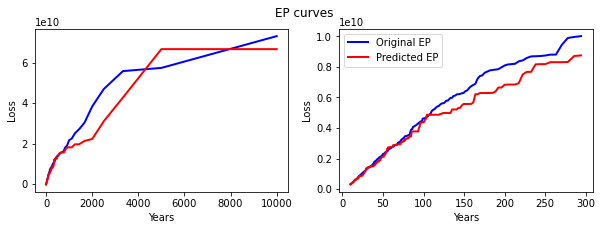

In [126]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

test= test.sort_values(by='Loss',ascending=False, ignore_index=True)
rank= [10000/i for i in range(1,test.shape[0]+1)]
rank= pd.DataFrame(rank)
test['rp']= rank.values

result= result.sort_values(by='predicted_loss',ascending=False, ignore_index=True)
result['rp']= rank.values
result2=result.loc[result.rp.between(10, 300, inclusive="both")]
test2=test.loc[test.rp.between(10, 300, inclusive="both")]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
fig.suptitle('EP curves')

ax1.plot(test['rp'], test['Loss'], color="blue", linewidth=2, label='Original EP')
ax1.plot(result['rp'], result['predicted_loss'], color="red", linewidth=2, label='Original EP')

ax2.plot(test2['rp'], test2['Loss'], color="blue", linewidth=2, label='Original EP')
ax2.plot(result2['rp'], result2['predicted_loss'], color="red", linewidth=2, label='Predicted EP')

ax1.set_xlabel('Years')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Years')
ax2.set_ylabel('Loss')

plt.legend()

plt.savefig('Comparison of  EP curve.png', format='png')

